<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN_LSTM/CNN_LSTM_Bund10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 1.53 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 21 15:50:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Bund10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN_LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len, time_distributed=True)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 4.4 MB/s 
     |████████████████████████████████| 138 kB 30.2 MB/s 
     |████████████████████████████████| 133 kB 26.2 MB/s 
     |████████████████████████████████| 97 kB 7.0 MB/s 
     |████████████████████████████████| 170 kB 30.8 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 62 kB 957 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=config.activation), input_shape=(None, window_len, 1)))
    # layer 2
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    # layer 3
    model.add(TimeDistributed(Flatten()))
    # layer 4
    model.add(LSTM(units=128, activation='tanh', return_sequences=False))
    # layer 5
    model.add(Dropout(0.1))
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: g7yqqqu7
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN_LSTM/sweeps/g7yqqqu7


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: t29kftaa with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
32/32 [==============================] - 37s 37ms/step - loss: 0.8131 - mean_squared_error: 0.8131 - mean_absolute_error: 0.4424 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1198
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - mean_absolute_error: 0.0958 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1102
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0805 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1399
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0720 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1071
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_squared_err

wandb: Agent Starting Run: bp1xf6pu with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 4s 61ms/step - loss: 0.0406 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1301 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1262
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0417 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1185
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0395 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1061
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0380 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0995
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0034 - mean_squared_err

wandb: Agent Starting Run: qguypzy9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 4s 77ms/step - loss: 0.0567 - mean_squared_error: 0.0567 - mean_absolute_error: 0.1444 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1305
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0416 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1191
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0370 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1063
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0424 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0984
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_squared_erro

wandb: Agent Starting Run: 1pcthfyd with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 4s 132ms/step - loss: 0.0698 - mean_squared_error: 0.0698 - mean_absolute_error: 0.1861 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1382
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0426 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1306
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0408 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1257
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0387 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1219
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0027 -

wandb: Agent Starting Run: 99xe11z3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
32/32 [==============================] - 4s 32ms/step - loss: 0.1053 - mean_squared_error: 0.1053 - mean_absolute_error: 0.2593 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1474
Epoch 2/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0869 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1327
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0836 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1286
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0720 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1256
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0068 - mean_squared_erro

wandb: Agent Starting Run: dey2gxjp with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 4s 117ms/step - loss: 0.1461 - mean_squared_error: 0.1461 - mean_absolute_error: 0.3291 - val_loss: 0.1899 - val_mean_squared_error: 0.1899 - val_mean_absolute_error: 0.3724
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1373 - mean_squared_error: 0.1373 - mean_absolute_error: 0.3150 - val_loss: 0.1658 - val_mean_squared_error: 0.1658 - val_mean_absolute_error: 0.3427
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1138 - mean_squared_error: 0.1138 - mean_absolute_error: 0.2803 - val_loss: 0.1416 - val_mean_squared_error: 0.1416 - val_mean_absolute_error: 0.3120
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0957 - mean_squared_error: 0.0957 - mean_absolute_error: 0.2478 - val_loss: 0.1204 - val_mean_squared_error: 0.1204 - val_mean_absolute_error: 0.2825
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0746 - mean_squared_error: 0.0746

wandb: Agent Starting Run: d5t5yno1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 3s 58ms/step - loss: 0.1406 - mean_squared_error: 0.1406 - mean_absolute_error: 0.3216 - val_loss: 0.1719 - val_mean_squared_error: 0.1719 - val_mean_absolute_error: 0.3489
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.1085 - mean_squared_error: 0.1085 - mean_absolute_error: 0.2723 - val_loss: 0.1307 - val_mean_squared_error: 0.1307 - val_mean_absolute_error: 0.2953
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0832 - mean_squared_error: 0.0832 - mean_absolute_error: 0.2252 - val_loss: 0.1002 - val_mean_squared_error: 0.1002 - val_mean_absolute_error: 0.2508
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0588 - mean_squared_error: 0.0588 - mean_absolute_error: 0.1814 - val_loss: 0.0805 - val_mean_squared_error: 0.0805 - val_mean_absolute_error: 0.2217
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0493 - mean_squared_erro

wandb: Agent Starting Run: vvzzo1g9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 3s 116ms/step - loss: 0.0723 - mean_squared_error: 0.0723 - mean_absolute_error: 0.2033 - val_loss: 0.0366 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1633
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0619 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1310
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0630 - val_loss: 0.0348 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1590
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0607 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1251
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - me

wandb: Agent Starting Run: 7pishnn4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
32/32 [==============================] - 3s 30ms/step - loss: 0.0815 - mean_squared_error: 0.0815 - mean_absolute_error: 0.2231 - val_loss: 0.0372 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1604
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - mean_absolute_error: 0.1165 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1427
Epoch 3/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0852 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1332
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0667 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1294
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0050 - mean_squared_erro

wandb: Agent Starting Run: 9gx9gkxs with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 119ms/step - loss: 0.0573 - mean_squared_error: 0.0573 - mean_absolute_error: 0.1418 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1266
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0416 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1342
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0489 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1399
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0596 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1335
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0031 - mean_squared_error: 0.00

wandb: Agent Starting Run: 2ovhlmtv with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 3s 32ms/step - loss: 0.0555 - mean_squared_error: 0.0555 - mean_absolute_error: 0.1628 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1433
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0512 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1146
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0406 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1080
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0372 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1016
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.

wandb: Agent Starting Run: 4sv7bxce with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 4s 31ms/step - loss: 0.1854 - mean_squared_error: 0.1854 - mean_absolute_error: 0.3032 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1164
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0547 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1265
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0463 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1018
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0356 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0960
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0018 - mean_squared_erro

wandb: Agent Starting Run: 3lnmf3qw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 3s 60ms/step - loss: 0.1527 - mean_squared_error: 0.1527 - mean_absolute_error: 0.3313 - val_loss: 0.1513 - val_mean_squared_error: 0.1513 - val_mean_absolute_error: 0.3219
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0823 - mean_squared_error: 0.0823 - mean_absolute_error: 0.2258 - val_loss: 0.0868 - val_mean_squared_error: 0.0868 - val_mean_absolute_error: 0.2305
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0482 - mean_squared_error: 0.0482 - mean_absolute_error: 0.1589 - val_loss: 0.0577 - val_mean_squared_error: 0.0577 - val_mean_absolute_error: 0.1888
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1351 - val_loss: 0.0467 - val_mean_squared_error: 0.0467 - val_mean_absolute_error: 0.1741
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0278 - mean_squared_erro

wandb: Agent Starting Run: 6inxegld with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 116ms/step - loss: 0.1569 - mean_squared_error: 0.1569 - mean_absolute_error: 0.3384 - val_loss: 0.2005 - val_mean_squared_error: 0.2005 - val_mean_absolute_error: 0.3804
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1279 - mean_squared_error: 0.1279 - mean_absolute_error: 0.2993 - val_loss: 0.1583 - val_mean_squared_error: 0.1583 - val_mean_absolute_error: 0.3296
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1005 - mean_squared_error: 0.1005 - mean_absolute_error: 0.2533 - val_loss: 0.1212 - val_mean_squared_error: 0.1212 - val_mean_absolute_error: 0.2792
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0725 - mean_squared_error: 0.0725 - mean_absolute_error: 0.2034 - val_loss: 0.0941 - val_mean_squared_error: 0.0941 - val_mean_absolute_error: 0.2398
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0539 - mean_squared_error: 0.053

wandb: Agent Starting Run: o3lkk9it with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 4s 62ms/step - loss: 0.0671 - mean_squared_error: 0.0671 - mean_absolute_error: 0.1953 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.1467
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0413 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1341
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0396 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1276
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0364 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1203
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0019 - mean_squared_error: 

wandb: Agent Starting Run: rbbtczmm with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 4s 117ms/step - loss: 0.0711 - mean_squared_error: 0.0711 - mean_absolute_error: 0.2032 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1610
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0626 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1318
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0675 - val_loss: 0.0362 - val_mean_squared_error: 0.0362 - val_mean_absolute_error: 0.1616
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0630 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1250
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0037 - mean_squared_error: 0.0037

wandb: Agent Starting Run: 3gacpv5p with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 4s 61ms/step - loss: 0.3737 - mean_squared_error: 0.3737 - mean_absolute_error: 0.3055 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1559
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0914 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1357
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0742 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1040
Epoch 4/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0388 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0984
Epoch 5/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0041 - mean_squared_er

wandb: Agent Starting Run: nfu3p9fu with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 116ms/step - loss: 0.0784 - mean_squared_error: 0.0784 - mean_absolute_error: 0.2293 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1402
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0467 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1426
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0416 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1328
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0372 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1334
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0023 - mean_squared_error: 0.00

wandb: Agent Starting Run: wm7cpgic with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 4s 32ms/step - loss: 0.0383 - mean_squared_error: 0.0383 - mean_absolute_error: 0.1407 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1373
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0448 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1308
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0392 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1217
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0357 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1159
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0019 - mean_squared_erro

wandb: Agent Starting Run: w6d204sz with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 3s 32ms/step - loss: 0.0501 - mean_squared_error: 0.0501 - mean_absolute_error: 0.1386 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1195
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0505 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1275
Epoch 3/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0603 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1058
Epoch 4/200
32/32 [==============================] - 1s 21ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0452 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1046
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_squared_err

wandb: Agent Starting Run: 0gms35kx with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 3s 30ms/step - loss: 0.1848 - mean_squared_error: 0.1848 - mean_absolute_error: 0.2998 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1217
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0565 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1080
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0460 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1082
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0398 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0940
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_squared_erro

wandb: Agent Starting Run: sgcwbqaf with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 3s 31ms/step - loss: 0.0793 - mean_squared_error: 0.0793 - mean_absolute_error: 0.1580 - val_loss: 0.0707 - val_mean_squared_error: 0.0707 - val_mean_absolute_error: 0.2262
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0987 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1092
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0722 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0915
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0510 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1090
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_squared_error: 0.

wandb: Agent Starting Run: yfs9mlpd with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 4s 65ms/step - loss: 0.0273 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1002 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1187
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0512 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1142
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0466 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1132
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0538 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1055
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0

wandb: Agent Starting Run: 5h9k343i with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 4s 122ms/step - loss: 0.5483 - mean_squared_error: 0.5483 - mean_absolute_error: 0.4157 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1344
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0689 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1419
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0941 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1298
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0585 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1215
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.00

wandb: Agent Starting Run: 2bda495b with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 58ms/step - loss: 0.0557 - mean_squared_error: 0.0557 - mean_absolute_error: 0.1690 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1296
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0624 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1163
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0482 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1143
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0430 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1114
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_squared_erro

wandb: Agent Starting Run: i1rlmgl0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 126ms/step - loss: 0.0771 - mean_squared_error: 0.0771 - mean_absolute_error: 0.2089 - val_loss: 0.0431 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1766
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0641 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1353
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0706 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1558
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0651 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1280
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.00

wandb: Agent Starting Run: y7wh92m1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 62ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1442 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1183
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0749 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1120
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0498 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1075
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0596 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1029
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0040 - mean_squared_error: 0

wandb: Agent Starting Run: 411osyn3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 4s 61ms/step - loss: 0.0629 - mean_squared_error: 0.0629 - mean_absolute_error: 0.1657 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1298
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0420 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1071
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0526 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1027
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0554 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1068
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 

wandb: Agent Starting Run: pobd7l9a with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 59ms/step - loss: 0.0401 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1281 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1389
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0439 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1415
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0477 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1382
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0427 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1189
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0052 - mean_squared_erro

wandb: Agent Starting Run: 0ty6k50d with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 4s 60ms/step - loss: 0.0511 - mean_squared_error: 0.0511 - mean_absolute_error: 0.1661 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1406
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0393 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1301
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0368 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1239
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0364 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1223
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0023 - mean_squared_error:

wandb: Agent Starting Run: xp069ts7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 64,
    'learning_rate': 0.0005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=best_config['activation']), input_shape=(None, window_len, 1)))
# layer 2
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# layer 3
model.add(TimeDistributed(Flatten()))
# layer 4
model.add(LSTM(units=128, activation='tanh', return_sequences=False))
# layer 5
model.add(Dropout(0.1))
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  984065


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 29, 128)     384       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 14, 128)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1792)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               983552    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 984,065
Trainable params: 984,065
Non-trainable params: 0
__________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100


20/20 [==============================] - 2s 4ms/step - loss: 0.0434
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 11/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 12/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 13/100
20/20 [=============================

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

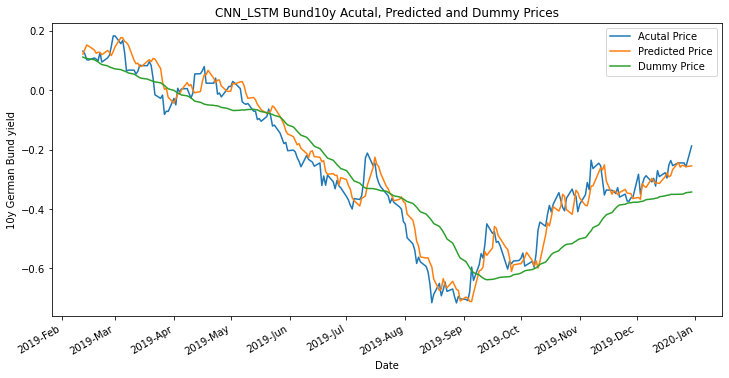

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

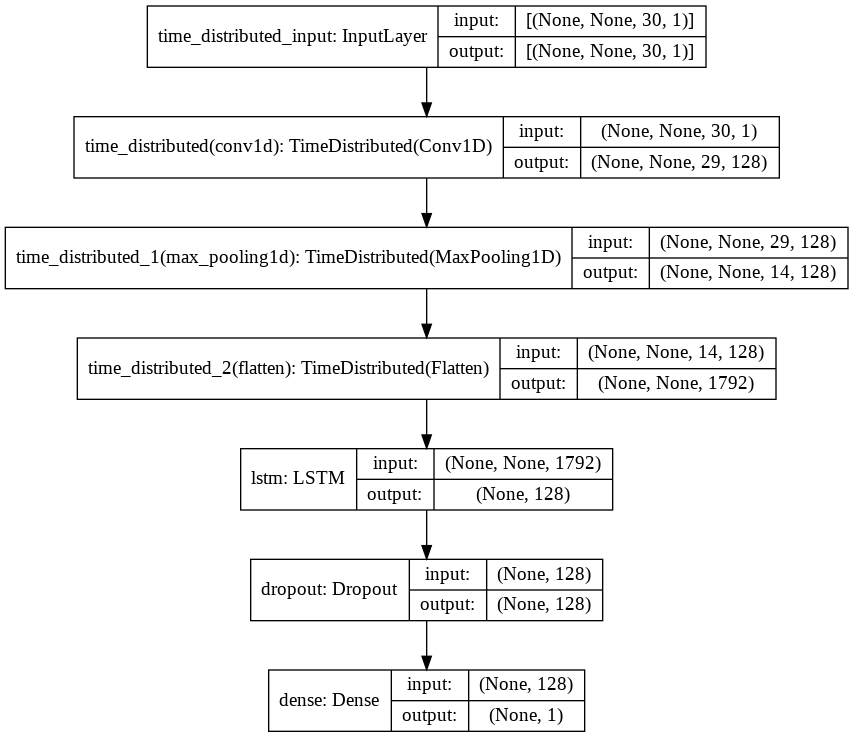

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.003779045371385389
RMSE:  0.06147394058774327
MAE:  0.04872198363642891
Dummy MSE:  0.01192499274023522
Dummy RMSE:  0.10920161509902324
Dummy MAE:  0.0887186459104488


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_LSTM_Bund10y/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_LSTM_Bund10y/assets
